In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import SimpleRNN, Input, Dense
from keras.models import Sequential

In [3]:
data=pd.read_csv("DMC_330020_Quinta_Normal_Santiago_media.csv",sep=";")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19995 entries, 0 to 19994
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    19995 non-null  int64 
 1   month   19995 non-null  int64 
 2   day     19995 non-null  int64 
 3   value   19995 non-null  object
dtypes: int64(3), object(1)
memory usage: 625.0+ KB


In [5]:
data["value"]=data["value"].apply(lambda x: float(x.replace(",",".")))
Y=data[(data["year"] == 2022) | (data["year"]==2021)]
y=Y["value"].to_numpy()
T=data[(data["year"] == 2023)]
t=T["value"].to_numpy()

In [6]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 18821 to 19550
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    730 non-null    int64  
 1   month   730 non-null    int64  
 2   day     730 non-null    int64  
 3   value   730 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 28.5 KB


In [7]:
T.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 19551 to 19915
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    365 non-null    int64  
 1   month   365 non-null    int64  
 2   day     365 non-null    int64  
 3   value   365 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 14.3 KB


In [8]:
Y.tail(n=12)

,year,month,day,value
19539,2022,12,20,20.6
19540,2022,12,21,22.5
19541,2022,12,22,20.9
19542,2022,12,23,21.3
19543,2022,12,24,22.6
19544,2022,12,25,21.5
19545,2022,12,26,18.6
19546,2022,12,27,21.2
19547,2022,12,28,22.6
19548,2022,12,29,24.1


In [9]:
T.tail(n=12)

,year,month,day,value
19904,2023,12,20,18.7
19905,2023,12,21,20.9
19906,2023,12,22,21.4
19907,2023,12,23,23.3
19908,2023,12,24,20.6
19909,2023,12,25,23.4
19910,2023,12,26,21.7
19911,2023,12,27,19.8
19912,2023,12,28,16.6
19913,2023,12,29,20.2


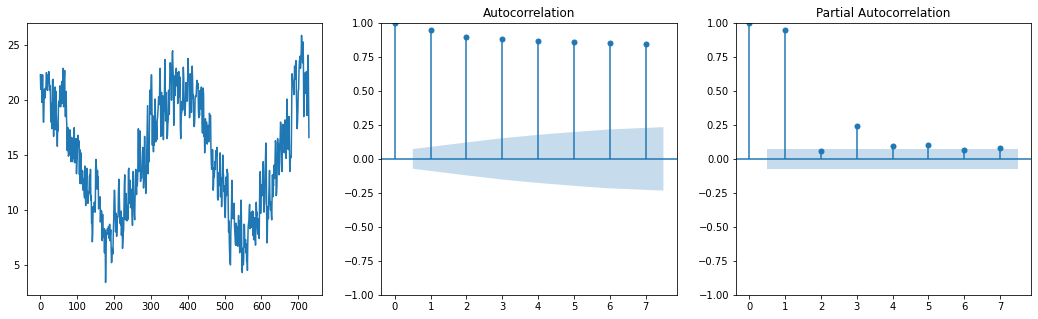

In [10]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, axes = plt.subplots(1,3)
fig.set_size_inches(18, 5)
axes[0].plot([i for i in range(len(y))],y)
plot_acf(y,ax=axes[1],lags=7);
plot_pacf(y,method="ywm",lags=7,ax=axes[2]);

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

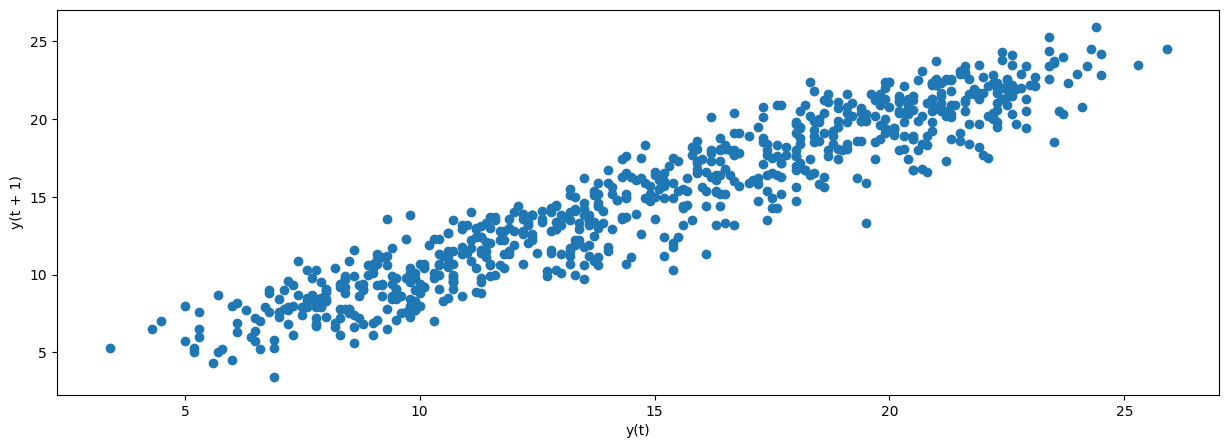

In [33]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 5)
pd.plotting.lag_plot(Y["value"], lag=1,ax=axes)

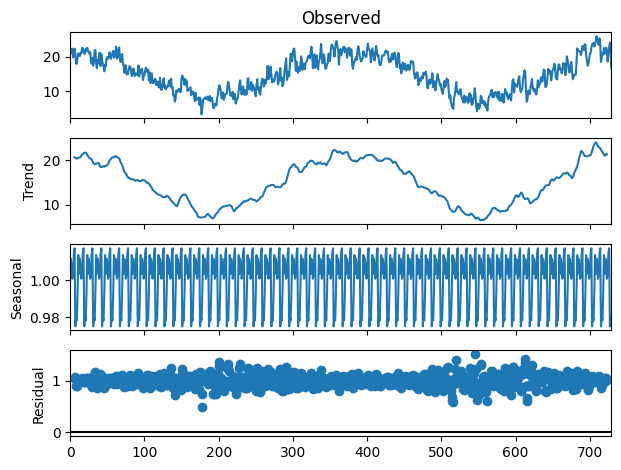

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

result=seasonal_decompose(y,model="multiplicative",period=12)
result.plot();

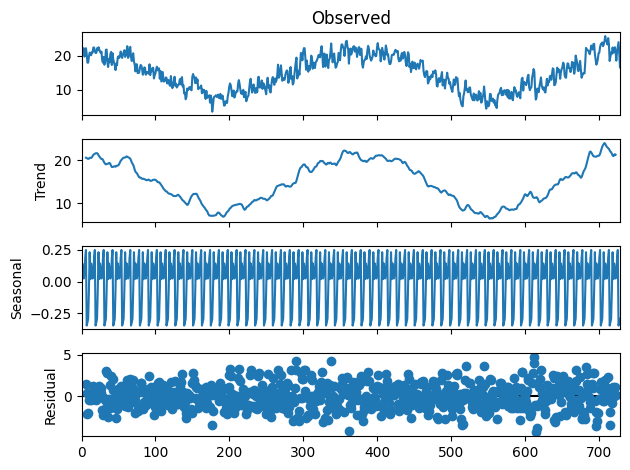

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

result=seasonal_decompose(y,model="additive",period=12)
result.plot();

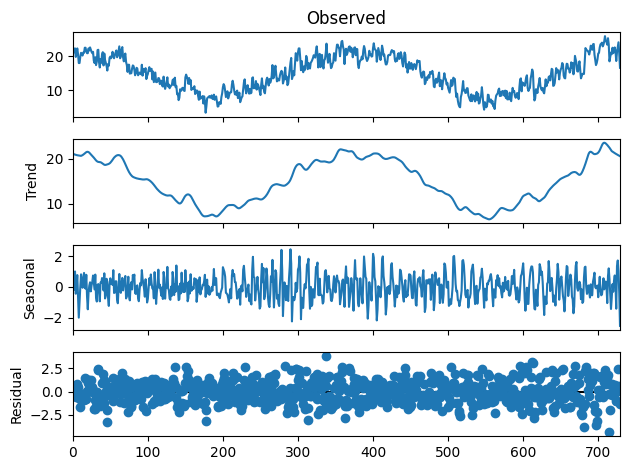

In [36]:
from statsmodels.tsa.seasonal import STL

stl = STL(y,period=12)
res_new = stl.fit()
res_new.plot();

Cuando se rechaza la hipótesis del test (p<0.05), la serie es estacionaria, de lo contrario no es estacionaria

In [37]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y,maxlag=1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.224816
p-value: 0.000598
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


In [38]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.039830
p-value: 0.269387
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [40]:
from pmdarima.arima import CHTest
from pmdarima.arima import nsdiffs

CHTest(m=180).estimate_seasonal_differencing_term(y)

1

In [41]:
x=[i for i in range(1,len(y)+1)]

In [46]:
xf=[i for i in range(len(y)+1,len(y)+len(t)+1)]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE 2.7699926241955253
AIC 2795.5185335121932


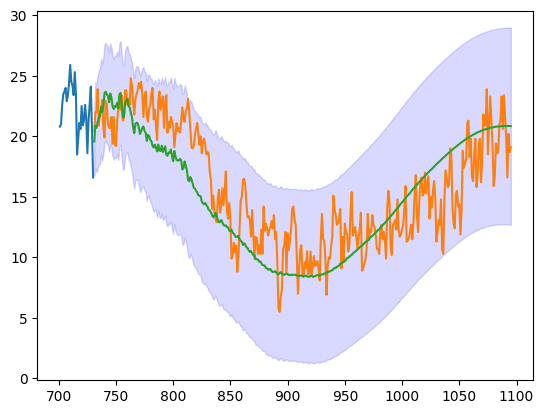

In [56]:
modelo1=ARIMA(y,order=(90,1,3))
m1=modelo1.fit()
m1_p = m1.get_forecast(steps=len(t))
m1_ci = m1_p.conf_int(0.05)
plt.plot(x[700:],y[700:],xf,t,xf,m1_p.predicted_mean)
plt.fill_between(xf, m1_ci[:,0], m1_ci[:,1], color='b', alpha=.15);
print("MSE",m1.mse)
print("AIC",m1.aic)

In [60]:
from scipy.stats import pearsonr
print("correlacion con 2022",pearsonr(y[365:],m1_p.predicted_mean))
print("correlacion con 2023",pearsonr(t,m1_p.predicted_mean))

correlacion con 2022 PearsonRResult(statistic=0.9128049961916557, pvalue=3.044590985043414e-143)
correlacion con 2023 PearsonRResult(statistic=0.8286299667674051, pvalue=1.7290404136378676e-93)
